In [1]:
%%time
spark

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.5 µs


In [1]:
!pip install --upgrade colorama
from pysparkling import *
import h2o
hc = H2OContext.getOrCreate(spark)

  Using cached colorama-0.3.9-py2.py3-none-any.whl
  Found existing installation: colorama 0.3.7
    Uninstalling colorama-0.3.7:
      Successfully uninstalled colorama-0.3.7
[WARNING] H2O requires colorama module of version 0.3.8 or newer. You have version 0.3.7.
You can upgrade to the newest version of the module running from the command line
    $ pip3 install --upgrade colorama
Connecting to H2O server at http://172.17.0.2:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster version:,3.14.0.7
H2O cluster version age:,1 month and 14 days
H2O cluster name:,sparkling-water-jovyan_local-1512473803809
H2O cluster total nodes:,1
H2O cluster free memory:,53.14 Gb
H2O cluster total cores:,36
H2O cluster allowed cores:,36
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://172.17.0.2:54321
H2O connection proxy:,None



Sparkling Water Context:
 * H2O name: sparkling-water-jovyan_local-1512473803809
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (driver,172.17.0.2,54321)
  ------------------------

  Open H2O Flow in browser: http://172.17.0.2:54321 (CMD + click in Mac OSX)

    


In [2]:
import pandas as pd
import numpy as np
import pandas.io.sql as psql
# import pyodbc
import csv
import matplotlib.pyplot as plt
import seaborn as sns

### Seaborn style
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.float_format', lambda x: '{:,.1f}'.format(x))

%matplotlib inline

In [3]:
import pyspark
from pyspark import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import TimestampType

import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import pandas as pd
from sklearn import *
from sklearn import preprocessing
# import lightgbm as lgb
from multiprocessing import *
from sklearn.model_selection import StratifiedKFold


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/opt/conda/lib/python3.6/site-pac

In [4]:
holidays = spark.read.option("header", "true").csv("/home/jovyan/work/sparkling-water-2.2.2/data/flight/holidays.csv")

In [5]:
# holidaysPD = holidays.toPandas()
# holidaysPD.Country.value_counts()

holidayTypeFilter = ['Common Local holidays', 'National holiday', 'National Holiday']
# holidaysPD[holidaysPD['Holiday Type'].isin(holidayTypeFilter) &
#           holidaysPD['Country'].isin(['china', 'australia'])]
holidays2 = (holidays.where(F.col('Country').isin(['china', 'australia', 'canada']) &
                          F.col('Holiday Type').isin(holidayTypeFilter))
                     .withColumn('tmp', F.lit('depHoliday_'))
                     .withColumn('Country2', F.concat(F.col('tmp'), F.col('Country')))
                     .drop('tmp'))
holidays3_dep = holidays2.groupBy('Date').pivot('Country2').agg(F.first(F.col('Holiday Name')))

holidays2 = (holidays.where(F.col('Country').isin(['china', 'australia', 'canada']) &
                          F.col('Holiday Type').isin(holidayTypeFilter))
                     .withColumn('tmp', F.lit('retHoliday_'))
                     .withColumn('Country2', F.concat(F.col('tmp'), F.col('Country')))
                     .drop('tmp'))
holidays3_ret = holidays2.groupBy('Date').pivot('Country2').agg(F.first(F.col('Holiday Name')))

In [6]:
holidays2.count()
holidays2.toPandas().head(1000)

,Country,Year,Date,Holiday Name,Holiday Type,Weekday,Where It is Observed,Country2
0,australia,2017,2017-01-01,New Year's Day,National Holiday,Sunday,None,retHoliday_australia
1,australia,2017,2017-01-02,New Year's Day observed,National Holiday,Monday,None,retHoliday_australia
2,australia,2017,2017-01-26,Australia Day,National Holiday,Thursday,None,retHoliday_australia
3,australia,2017,2017-04-14,Good Friday,National Holiday,Friday,None,retHoliday_australia
4,australia,2017,2017-04-17,Easter Monday,National Holiday,Monday,None,retHoliday_australia
5,australia,2017,2017-04-25,ANZAC Day,National Holiday,Tuesday,All,retHoliday_australia
6,australia,2017,2017-12-25,Christmas Day,National Holiday,Monday,None,retHoliday_australia
7,australia,2017,2017-12-26,Boxing Day,National Holiday,Tuesday,None,retHoliday_australia
8,australia,2018,2018-01-01,New Year's Day,National Holiday,Monday,None,retHoliday_australia
9,australia,2018,2018-01-26,Australia Day,National Holiday,Friday,None,retHoliday_australia


In [7]:
df = sqlContext.read.parquet('/home/jovyan/work/sparkling-water-2.2.2/data/s3/flight.pq.11.comb')

In [8]:
df.count()

106453155

In [9]:
df.groupBy('fromCity', 'toCity').count().show(1000)

+--------+----------------+-------+
|fromCity|          toCity|  count|
+--------+----------------+-------+
|shanghai|            Rome|3935248|
|  sydney|       guangzhou|3882362|
|shanghai|          Nagoya|3827029|
|shanghai|           perth|3889111|
|shanghai|           Osaka|4038550|
|shanghai|          Taipei|3763238|
|shanghai|        hongkong|3898235|
|shanghai|         Bangkok|4676571|
|shanghai|       Singapore|3945487|
|shanghai|          Phuket|4662733|
|shanghai|Ho Chi Minh City| 252283|
|shanghai|        Auckland|2872468|
|  sydney|        hongkong|4231559|
|  sydney|         Chengdu|3815977|
|shanghai|      Chiang Mai|4166747|
|shanghai|          Manila| 263903|
|shanghai|           Tokyo|3745097|
|shanghai|           Seoul|3963685|
|shanghai|        Florence|3739509|
|shanghai|        Honolulu|3797508|
|  sydney|        shenzhen|3643081|
|shanghai|          sydney|4412482|
|shanghai|   San Francisco|3901264|
|shanghai|           Busan|3949131|
|shanghai|       Vancouver|3

In [10]:
# df_sample = df.sample(False, 0.1, 42)

In [11]:
# df_sample.count()

In [12]:
# df = df_sample

In [13]:
lookforwardDays = 7 #19
ndays = lambda i: i * 86400 # number of seconds in a day
byVar = ['toCity', 'depDate', 'stayDays', 'timeline1_departureTime_time', 'timeline2_departureTime_time',
         'timeline1_carrier_airlineCode', 'timeline2_carrier_airlineCode']

w = (Window.partitionBy('routeCombKey')
     .orderBy(F.col('searchDate').cast('timestamp').cast('long'))
     .rowsBetween(0, ndays(lookforwardDays)))

threshold = 20

udfGetWeekNumer = lambda dt: F.udf(dt.isocalendar()[1], IntegerType())
# udfGetAvg = lambda x: F.udf(sum(x)/float(len(x)))\n\n

df2 = (df.filter(df.price > 0)
       .withColumn('routeCombKey', F.concat_ws('-', F.col('fromCity'),
                                   F.col('toCity'),
                                   F.col('stayDays'), F.col('depDate'),
                                   F.col('timeline1_departureTime_time'),
                                   F.col('timeline2_departureTime_time'),
                                   F.col('timeline1_carrier_airlineCode'),
                                   F.col('timeline2_carrier_airlineCode')))
                                   # join_udf(F.col('timeline1_departureTime_time')),
                                   # join_udf(F.col('timeline2_departureTime_time')),
                                   # join_udf(F.col('timeline1_carrier_airlineCode')),
                                   # join_udf(F.col('timeline2_carrier_airlineCode'))))
       .withColumn('futureMinPrice', F.min(F.col('price')).over(w))
       .withColumn('priceWillDrop', (F.col('price') - F.col('futureMinPrice') > threshold).cast('int'))
       .withColumn('saving0', F.col('price') - F.col('futureMinPrice'))
       .withColumn('temp0', F.lit(0))
       .withColumn('saving', F.greatest('saving0', 'temp0'))
       .drop('saving0', 'temp0')
       .withColumn('leadTime', F.datediff(F.col('depDate'), F.col('searchDate')))
       .withColumn('depWeekOfYear', F.weekofyear(F.col('depDate')))
       .withColumn('retWeekOfYear', F.weekofyear(F.col('leg2_departureTime_date')))
       .withColumn('depMonth', F.month(F.col('depDate')))
       .withColumn('depDayOfMonth', F.dayofmonth(F.col('depDate')))
       .withColumn('depDayOfYear', F.dayofyear(F.col('depDate')))
       .withColumn('depDayOfWeek', F.date_format(F.col('depDate'), 'EEEE'))
       .withColumn('retDayOfWeek', F.date_format(F.col('leg2_departureTime_date'), 'EEEE'))
       .withColumn('searchDayOfWeek', F.date_format(F.col('searchDate'), 'EEEE'))
       .withColumn('leg1_noOfTicketsLeft', 
                   F.when(F.col('leg1_carrierSummary_noOfTicketsLeft') > 0, 
                          F.col('leg1_carrierSummary_noOfTicketsLeft')).otherwise(99))
        .withColumn('leg2_noOfTicketsLeft', 
                    F.when(F.col('leg2_carrierSummary_noOfTicketsLeft') > 0, 
                           F.col('leg2_carrierSummary_noOfTicketsLeft')).otherwise(99))
       .withColumn('leg1_cabinClass_0', F.col('timeline1_carrier_cabinClass').getItem(0))
       .withColumn('leg1_cabinClass_1', F.col('timeline1_carrier_cabinClass').getItem(1))
       .withColumn('leg1_cabinClass_2', F.col('timeline1_carrier_cabinClass').getItem(2))
       .withColumn('leg2_cabinClass_0', F.col('timeline2_carrier_cabinClass').getItem(0))
       .withColumn('leg2_cabinClass_1', F.col('timeline2_carrier_cabinClass').getItem(1))
       .withColumn('leg2_cabinClass_2', F.col('timeline2_carrier_cabinClass').getItem(2))
       .withColumn('retDate', F.from_unixtime(F.unix_timestamp('leg2_departureTime_date', 
                                                               'dd/MM/yyyy'), 'yyyy-MM-dd'))
       .select('price', 'priceWillDrop', 'futureMinPrice', 'saving',
               'fromCity', 'toCity',
               'searchDate','depDate', 'retDate',
               'routeCombKey',
               'leadTime', 
               'leg1_stops', 'leg2_stops',
               'leg1_noOfTicketsLeft', 'leg2_noOfTicketsLeft',
               'leg1_carrierSummary_airlineName', 'leg2_carrierSummary_airlineName',
               'leg1_departureTime_hour', 'leg2_departureTime_hour',
               'depWeekOfYear', 'depDayOfWeek','retWeekOfYear', 'retDayOfWeek',
               'searchDayOfWeek',
               'leg1_cabinClass_0', 'leg1_cabinClass_1', 'leg1_cabinClass_2',
               'leg2_cabinClass_0', 'leg2_cabinClass_1', 'leg2_cabinClass_2',
               'trip')
      )

# df2.cache()

In [14]:
%%time
# Slow!
df3 = df2.filter(F.col('searchDate') <= F.lit('2017-06-23').cast(TimestampType()))
df3 = df3.withColumn('randVar', F.round(F.rand()*200, 0))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 61.2 ms


In [15]:
# %%time #WARNING: very slow
# df3.toPandas().head()

In [16]:
(df3.join(holidays2, df3.depDate==holidays2.Date, how='left')
     .groupBy('Country', 'Holiday Type', 'depDate', 'Holiday Name').count()
     .filter(F.col('Holiday Type') == 'National holiday').show(1000))

+-------+----------------+----------+--------------------+------+
|Country|    Holiday Type|   depDate|        Holiday Name| count|
+-------+----------------+----------+--------------------+------+
|  china|National holiday|2017-10-03|National Day Gold...|473355|
|  china|National holiday|2017-10-02|National Day Gold...|474899|
| canada|National holiday|2017-10-09|    Thanksgiving Day|472103|
| canada|National holiday|2017-09-04|          Labour Day|480988|
|  china|National holiday|2017-10-04| Mid-Autumn Festival|473987|
| canada|National holiday|2017-11-11|     Remembrance Day|439949|
|  china|National holiday|2017-05-29|Dragon Boat Festi...|190224|
|  china|National holiday|2017-05-30|Dragon Boat Festival|203893|
| canada|National holiday|2017-07-01|          Canada Day|473168|
|  china|National holiday|2017-05-28|Dragon Boat Festi...|177557|
|  china|National holiday|2017-10-01|        National Day|469531|
| canada|National holiday|2017-07-03|Canada Day - addi...|477829|
| canada|N

In [17]:
%%time
# df4 = (df3.join(holidays3_dep, df3.depDate==holidays3_dep.Date, how='left').drop('Date')
#           .join(holidays3_ret, df3.retDate==holidays3_ret.Date, how='left').drop('Date'))

# df4.show(1)
df4 = df3

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs


In [18]:
# !mkdir /home/jovyan/.local/h2o_jar
# !cp /home/jovyan/work/h2o-3.14.0.7/h2o.jar /home/jovyan/.local/h2o_jar
# # H2O

# # turn off proxy so that h2o can run properly
# import os
# # os.environ.pop("HTTP_PROXY")

# import h2o
# h2o.init(nthreads = -1)

In [19]:
df4.printSchema()

root
 |-- price: double (nullable = true)
 |-- priceWillDrop: integer (nullable = true)
 |-- futureMinPrice: double (nullable = true)
 |-- saving: double (nullable = false)
 |-- fromCity: string (nullable = true)
 |-- toCity: string (nullable = true)
 |-- searchDate: string (nullable = true)
 |-- depDate: string (nullable = true)
 |-- retDate: string (nullable = true)
 |-- routeCombKey: string (nullable = false)
 |-- leadTime: integer (nullable = true)
 |-- leg1_stops: long (nullable = true)
 |-- leg2_stops: long (nullable = true)
 |-- leg1_noOfTicketsLeft: long (nullable = true)
 |-- leg2_noOfTicketsLeft: long (nullable = true)
 |-- leg1_carrierSummary_airlineName: string (nullable = true)
 |-- leg2_carrierSummary_airlineName: string (nullable = true)
 |-- leg1_departureTime_hour: long (nullable = true)
 |-- leg2_departureTime_hour: long (nullable = true)
 |-- depWeekOfYear: integer (nullable = true)
 |-- depDayOfWeek: string (nullable = true)
 |-- retWeekOfYear: integer (nullable = t

In [20]:
# df4.groupBy('depHoliday_australia', 'depHoliday_china', 'depHoliday_canada',
#             'retHoliday_australia', 'retHoliday_china', 'retHoliday_canada').count().show(100)

In [45]:
df4_train = df4.filter(F.col('searchDate') < F.lit('2017-06-01').cast(TimestampType())).sample(False, 0.5, 42)
df4_valid = df4.filter((F.col('searchDate') <= F.lit('2017-06-23').cast(TimestampType())) &
                      (F.col('searchDate') >= F.lit('2017-06-01').cast(TimestampType()))).sample(False, 0.5, 42)

In [46]:
df4_train.count(), df4_valid.count()

(21260753, 21345740)

In [47]:
%%time
hf_train = hc.as_h2o_frame(df4_train)
hf_valid = hc.as_h2o_frame(df4_valid)

CPU times: user 68 ms, sys: 12 ms, total: 80 ms
Wall time: 4min 27s


In [48]:
hf_train.head(5)

price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar
720.5,0,720.5,0,shanghai,Auckland,2017-05-12,2017-05-17,2017-11-21,shanghai-Auckland-0-2017-05-17-8:20pm-11:50am-1:25pm-9:30pm-MU-NZ-MF-MF,5,1,1,7,5,,Xiamen Airlines,20,13,20,Wednesday,nan,,Friday,3,3,,3,3,,1,39
721.2,0,721.2,0,shanghai,Auckland,2017-05-14,2017-05-17,2017-11-21,shanghai-Auckland-0-2017-05-17-8:20pm-11:50am-1:25pm-9:30pm-MU-NZ-MF-MF,3,1,1,7,5,,Xiamen Airlines,20,13,20,Wednesday,nan,,Sunday,3,3,,3,3,,1,76
721.2,0,721.2,0,shanghai,Auckland,2017-05-15,2017-05-17,2017-11-21,shanghai-Auckland-0-2017-05-17-8:20pm-11:50am-1:25pm-9:30pm-MU-NZ-MF-MF,2,1,1,7,5,,Xiamen Airlines,20,13,20,Wednesday,nan,,Monday,3,3,,3,3,,1,64
1111.2,1,1045.8,65.4,shanghai,Auckland,2017-05-12,2017-05-18,2017-11-21,shanghai-Auckland-0-2017-05-18-4:00pm-11:00pm-8:45am-1:25pm-9:30pm-PR-PR-PR-MF-MF,6,2,1,7,5,Philippine Airlines,Xiamen Airlines,16,13,20,Thursday,nan,,Friday,3,3,3,3,3,,1,112
1357.4,0,1357.4,0,shanghai,Auckland,2017-05-15,2017-05-18,2017-11-21,shanghai-Auckland-0-2017-05-18-4:00pm-11:00pm-8:45am-1:25pm-9:30pm-PR-PR-PR-MF-MF,3,2,1,7,5,Philippine Airlines,Xiamen Airlines,16,13,20,Thursday,nan,,Monday,3,3,3,3,3,,1,118


In [49]:
hf_train.describe()

hf_train.types

hf_train['leg1_carrierSummary_airlineName'].levels()

hf_train['depDayOfWeek'].levels()

# hf['JV_X_Excess'] = hf.interaction(['JV Description', 'Destination'], pairwise=False, max_factors=10, min_occurrence=500)

hf_train.columns

Rows:21256930
Cols:32




,price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar
type,real,int,real,real,string,string,string,string,string,string,int,int,int,int,int,string,string,int,int,int,string,int,string,string,string,string,string,string,string,string,int,int
mins,81.50999999999999,0.0,76.88,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,NaN,NaN,0.0,0.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
mean,1397.9735057254272,0.3848352513744929,1330.6469278047205,67.32657792070636,NaN,NaN,NaN,NaN,NaN,NaN,90.56115215132195,0.9661588479615817,0.7855040685555253,26.716316937582242,26.762690049786134,NaN,NaN,12.822129300891515,12.669941096856414,33.51855592505597,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8125939164310174,99.99278545867166
maxs,27406.8,1.0,27406.8,14277.410000000003,NaN,NaN,NaN,NaN,NaN,NaN,180.0,6.0,3.0,99.0,99.0,NaN,NaN,23.0,23.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,200.0
sigma,1269.920972532807,0.48655636036430644,1226.705153876594,234.72170127515352,NaN,NaN,NaN,NaN,NaN,NaN,51.913707248825574,0.4389511561215742,0.45874741150787535,38.123076007815946,38.799030074728314,NaN,NaN,5.664625883070559,5.768380234911308,7.472840677946541,NaN,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3902371722098455,57.74566076983402
zeros,0,13076514,0,4762747,0,0,0,0,0,0,0,2395201,5004418,0,0,0,0,747553,823841,0,0,0,0,0,0,0,0,0,0,0,0,53372
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21256930,21256930,0,0,2395201,19595762,0,5004418,20813139,0,0
0,720.5,0.0,720.5,0.0,shanghai,Auckland,2017-05-12,2017-05-17,2017-11-21,shanghai-Auckland-0-2017-05-17-8:20pm-11:50am-1:25pm-9:30pm-MU-NZ-MF-MF,5.0,1.0,1.0,7.0,5.0,,Xiamen Airlines,20.0,13.0,20.0,Wednesday,nan,,Friday,3,3,,3,3,,1.0,39.0
1,721.2,0.0,721.2,0.0,shanghai,Auckland,2017-05-14,2017-05-17,2017-11-21,shanghai-Auckland-0-2017-05-17-8:20pm-11:50am-1:25pm-9:30pm-MU-NZ-MF-MF,3.0,1.0,1.0,7.0,5.0,,Xiamen Airlines,20.0,13.0,20.0,Wednesday,nan,,Sunday,3,3,,3,3,,1.0,76.0
2,721.2,0.0,721.2,0.0,shanghai,Auckland,2017-05-15,2017-05-17,2017-11-21,shanghai-Auckland-0-2017-05-17-8:20pm-11:50am-1:25pm-9:30pm-MU-NZ-MF-MF,2.0,1.0,1.0,7.0,5.0,,Xiamen Airlines,20.0,13.0,20.0,Wednesday,nan,,Monday,3,3,,3,3,,1.0,64.0


['price',
 'priceWillDrop',
 'futureMinPrice',
 'saving',
 'fromCity',
 'toCity',
 'searchDate',
 'depDate',
 'retDate',
 'routeCombKey',
 'leadTime',
 'leg1_stops',
 'leg2_stops',
 'leg1_noOfTicketsLeft',
 'leg2_noOfTicketsLeft',
 'leg1_carrierSummary_airlineName',
 'leg2_carrierSummary_airlineName',
 'leg1_departureTime_hour',
 'leg2_departureTime_hour',
 'depWeekOfYear',
 'depDayOfWeek',
 'retWeekOfYear',
 'retDayOfWeek',
 'searchDayOfWeek',
 'leg1_cabinClass_0',
 'leg1_cabinClass_1',
 'leg1_cabinClass_2',
 'leg2_cabinClass_0',
 'leg2_cabinClass_1',
 'leg2_cabinClass_2',
 'trip',
 'randVar']

In [50]:
hf_train.types

{'depDate': 'string',
 'depDayOfWeek': 'string',
 'depWeekOfYear': 'int',
 'fromCity': 'string',
 'futureMinPrice': 'real',
 'leadTime': 'int',
 'leg1_cabinClass_0': 'string',
 'leg1_cabinClass_1': 'string',
 'leg1_cabinClass_2': 'string',
 'leg1_carrierSummary_airlineName': 'string',
 'leg1_departureTime_hour': 'int',
 'leg1_noOfTicketsLeft': 'int',
 'leg1_stops': 'int',
 'leg2_cabinClass_0': 'string',
 'leg2_cabinClass_1': 'string',
 'leg2_cabinClass_2': 'string',
 'leg2_carrierSummary_airlineName': 'string',
 'leg2_departureTime_hour': 'int',
 'leg2_noOfTicketsLeft': 'int',
 'leg2_stops': 'int',
 'price': 'real',
 'priceWillDrop': 'int',
 'randVar': 'int',
 'retDate': 'string',
 'retDayOfWeek': 'string',
 'retWeekOfYear': 'int',
 'routeCombKey': 'string',
 'saving': 'real',
 'searchDate': 'string',
 'searchDayOfWeek': 'string',
 'toCity': 'string',
 'trip': 'int'}

In [51]:
features = ['price',
         'fromCity',
         'toCity', 
         'leadTime',
         'leg1_stops',
         'leg2_stops',
         'leg1_noOfTicketsLeft',
         'leg2_noOfTicketsLeft',
         'leg1_carrierSummary_airlineName',
         'leg2_carrierSummary_airlineName',
         'leg1_departureTime_hour',
         'leg2_departureTime_hour',
         'depWeekOfYear',
         'depDayOfWeek',
         'retWeekOfYear',
         'retDayOfWeek',
         'searchDayOfWeek',
         'leg1_cabinClass_0',
         
         
         'leg2_cabinClass_0',
         
         
         'trip',
#          'depHoliday_australia', 'depHoliday_china', 'depHoliday_canada',
#          'retHoliday_australia', 'retHoliday_china', 'retHoliday_canada'
         ]

target = 'priceWillDrop'

other_cols = [ 'futureMinPrice', 'saving','searchDate', 'routeCombKey','randVar',
             'leg1_cabinClass_2','leg2_cabinClass_2','leg1_cabinClass_1','leg2_cabinClass_1',]

features, target

hf_train.describe()

Rows:21256930
Cols:32




,price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar
type,real,int,real,real,string,string,string,string,string,string,int,int,int,int,int,string,string,int,int,int,string,int,string,string,string,string,string,string,string,string,int,int
mins,81.50999999999999,0.0,76.88,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,NaN,NaN,0.0,0.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
mean,1397.9735057254272,0.3848352513744929,1330.6469278047205,67.32657792070636,NaN,NaN,NaN,NaN,NaN,NaN,90.56115215132195,0.9661588479615817,0.7855040685555253,26.716316937582242,26.762690049786134,NaN,NaN,12.822129300891515,12.669941096856414,33.51855592505597,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8125939164310174,99.99278545867166
maxs,27406.8,1.0,27406.8,14277.410000000003,NaN,NaN,NaN,NaN,NaN,NaN,180.0,6.0,3.0,99.0,99.0,NaN,NaN,23.0,23.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,200.0
sigma,1269.920972532807,0.48655636036430644,1226.705153876594,234.72170127515352,NaN,NaN,NaN,NaN,NaN,NaN,51.913707248825574,0.4389511561215742,0.45874741150787535,38.123076007815946,38.799030074728314,NaN,NaN,5.664625883070559,5.768380234911308,7.472840677946541,NaN,-0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3902371722098455,57.74566076983402
zeros,0,13076514,0,4762747,0,0,0,0,0,0,0,2395201,5004418,0,0,0,0,747553,823841,0,0,0,0,0,0,0,0,0,0,0,0,53372
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21256930,21256930,0,0,2395201,19595762,0,5004418,20813139,0,0
0,720.5,0.0,720.5,0.0,shanghai,Auckland,2017-05-12,2017-05-17,2017-11-21,shanghai-Auckland-0-2017-05-17-8:20pm-11:50am-1:25pm-9:30pm-MU-NZ-MF-MF,5.0,1.0,1.0,7.0,5.0,,Xiamen Airlines,20.0,13.0,20.0,Wednesday,nan,,Friday,3,3,,3,3,,1.0,39.0
1,721.2,0.0,721.2,0.0,shanghai,Auckland,2017-05-14,2017-05-17,2017-11-21,shanghai-Auckland-0-2017-05-17-8:20pm-11:50am-1:25pm-9:30pm-MU-NZ-MF-MF,3.0,1.0,1.0,7.0,5.0,,Xiamen Airlines,20.0,13.0,20.0,Wednesday,nan,,Sunday,3,3,,3,3,,1.0,76.0
2,721.2,0.0,721.2,0.0,shanghai,Auckland,2017-05-15,2017-05-17,2017-11-21,shanghai-Auckland-0-2017-05-17-8:20pm-11:50am-1:25pm-9:30pm-MU-NZ-MF-MF,2.0,1.0,1.0,7.0,5.0,,Xiamen Airlines,20.0,13.0,20.0,Wednesday,nan,,Monday,3,3,,3,3,,1.0,64.0


In [52]:
for feature in features:
    if hf_train.types[feature] == 'string':
        hf_train[feature] = hf_train[feature].asfactor()
        hf_valid[feature] = hf_valid[feature].asfactor()

In [53]:
hf_train.types

{'depDate': 'string',
 'depDayOfWeek': 'enum',
 'depWeekOfYear': 'int',
 'fromCity': 'enum',
 'futureMinPrice': 'real',
 'leadTime': 'int',
 'leg1_cabinClass_0': 'enum',
 'leg1_cabinClass_1': 'string',
 'leg1_cabinClass_2': 'string',
 'leg1_carrierSummary_airlineName': 'enum',
 'leg1_departureTime_hour': 'int',
 'leg1_noOfTicketsLeft': 'int',
 'leg1_stops': 'int',
 'leg2_cabinClass_0': 'enum',
 'leg2_cabinClass_1': 'string',
 'leg2_cabinClass_2': 'string',
 'leg2_carrierSummary_airlineName': 'enum',
 'leg2_departureTime_hour': 'int',
 'leg2_noOfTicketsLeft': 'int',
 'leg2_stops': 'int',
 'price': 'real',
 'priceWillDrop': 'int',
 'randVar': 'int',
 'retDate': 'string',
 'retDayOfWeek': 'enum',
 'retWeekOfYear': 'int',
 'routeCombKey': 'string',
 'saving': 'real',
 'searchDate': 'string',
 'searchDayOfWeek': 'enum',
 'toCity': 'enum',
 'trip': 'int'}

In [54]:
hf_train[target] = hf_train[target].asfactor()
hf_valid[target] = hf_valid[target].asfactor()

In [55]:
# factorFeatures=['depHoliday_australia',
#                  'depHoliday_china',
#                  'depHoliday_canada',
#                  'retHoliday_australia',
#                  'retHoliday_china',
#                  'retHoliday_canada']

# for feature in factorFeatures:
#     hf[feature] = hf[feature].asfactor()

In [56]:
hf_train['searchDate'].asfactor().table()

searchDate,Count
2017-05-12,1.05236e+06
2017-05-13,1.05174e+06
2017-05-14,1.05199e+06
2017-05-15,1.04920e+06
2017-05-16,933439
2017-05-17,970666
2017-05-18,1.04711e+06
2017-05-19,611879
2017-05-20,1.04453e+06
2017-05-21,1.07552e+06


In [57]:
hf_train['depDate'].asfactor().table()

depDate,Count
2017-05-13,5584
2017-05-14,11217
2017-05-15,16975
2017-05-16,22630
2017-05-17,28417
2017-05-18,32966
2017-05-19,39063
2017-05-20,42590
2017-05-21,47963
2017-05-22,54960


In [58]:
# hf[hf['leg1_cabinClass_1'].isna(), 'leg1_cabinClass_1'] = 0 #missing

In [59]:
# target = targets[0]
# target

# hf2 = hf[targets + features2]

# # hf2[hf2[target] <= 0, target]=0
# for target in targets:
#     hf2[hf2[target] > 0, target]=1
#     hf2[hf2[target] <= 0, target]=0
#     hf2[target] = hf2[target].asfactor()
# # for target in targets:
# #     hf2[hf2[target] <= 0, target]=0

# hf2[hf2['Lead Time'] < 0, 'Lead Time']=0
# hf2[hf2['Lead Time'] > 366, 'Lead Time']=366
# hf2[hf2['Trip Length'] < 0, 'Trip Length']=0
# hf2[hf2['Trip Length'] > 366, 'Trip Length']=366
# hf2['excess'] = hf2['excess'].asfactor()
# hf2[hf2['oldest age'] < 15, 'oldest age']=15
# hf2[hf2['oldest age'] >= 90, 'oldest age']=90
# hf2[hf2['Traveller Count'] >= 3, 'Traveller Count']=3

# df['searchDate'].value_counts()

In [60]:
import datetime

# hf['searchDate2'] = hf['searchDate'].as_date('%Y-%m-%d')
# train=hf




# train=hf[hf['searchDate2']<=datetime.datetime(2017, 6, 1, 0, 0, 0), :]
# valid=hf[(hf['searchDate2']>datetime.datetime(2017, 6, 7, 0, 0, 0)) & 
#          (hf['searchDate2']<=datetime.datetime(2017, 6, 21, 0, 0, 0)), :]
# # test=hf[hf['searchDate2']>datetime.datetime(2017, 6, 21, 0, 0, 0), :]

# train.shape, test.shape
# train.nrow, valid.nrow, test.nrow
# # splits = hf.split_frame(ratios=[0.7, 0.15], seed=1)  

# # train = splits[0]
# # valid = splits[1]
# # test = splits[2]

# # gbm_regressor.train(x=features, y=targets[0], training_frame=train)

# # gbm_regressor.model_performance(test)

In [61]:
hf_train.describe()

Rows:21256930
Cols:32




,price,priceWillDrop,futureMinPrice,saving,fromCity,toCity,searchDate,depDate,retDate,routeCombKey,leadTime,leg1_stops,leg2_stops,leg1_noOfTicketsLeft,leg2_noOfTicketsLeft,leg1_carrierSummary_airlineName,leg2_carrierSummary_airlineName,leg1_departureTime_hour,leg2_departureTime_hour,depWeekOfYear,depDayOfWeek,retWeekOfYear,retDayOfWeek,searchDayOfWeek,leg1_cabinClass_0,leg1_cabinClass_1,leg1_cabinClass_2,leg2_cabinClass_0,leg2_cabinClass_1,leg2_cabinClass_2,trip,randVar
type,real,enum,real,real,enum,enum,string,string,string,string,int,int,int,int,int,enum,enum,int,int,int,enum,int,enum,enum,enum,string,string,enum,string,string,int,int
mins,81.50999999999999,,76.88,0.0,,,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,1.0,,,0.0,0.0,19.0,,NaN,,,,NaN,NaN,,NaN,NaN,1.0,0.0
mean,1397.9735057254272,,1330.6469278047205,67.32657792070636,,,NaN,NaN,NaN,NaN,90.56115215132195,0.9661588479615817,0.7855040685555253,26.716316937582242,26.762690049786134,,,12.822129300891515,12.669941096856414,33.51855592505597,,0.0,,,,NaN,NaN,,NaN,NaN,1.8125939164310174,99.99278545867166
maxs,27406.8,,27406.8,14277.410000000003,,,NaN,NaN,NaN,NaN,180.0,6.0,3.0,99.0,99.0,,,23.0,23.0,48.0,,NaN,,,,NaN,NaN,,NaN,NaN,2.0,200.0
sigma,1269.920972532807,,1226.705153876594,234.72170127515352,,,NaN,NaN,NaN,NaN,51.913707248825574,0.4389511561215742,0.45874741150787535,38.123076007815946,38.799030074728314,,,5.664625883070559,5.768380234911308,7.472840677946541,,-0.0,,,,NaN,NaN,,NaN,NaN,0.3902371722098455,57.74566076983402
zeros,0,,0,4762747,,,0,0,0,0,0,2395201,5004418,0,0,,,747553,823841,0,,0,,,,0,0,,0,0,0,53372
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21256930,21256930,0,0,2395201,19595762,0,5004418,20813139,0,0
0,720.5,0,720.5,0.0,shanghai,Auckland,2017-05-12,2017-05-17,2017-11-21,shanghai-Auckland-0-2017-05-17-8:20pm-11:50am-1:25pm-9:30pm-MU-NZ-MF-MF,5.0,1.0,1.0,7.0,5.0,,Xiamen Airlines,20.0,13.0,20.0,Wednesday,nan,,Friday,3,3,,3,3,,1.0,39.0
1,721.2,0,721.2,0.0,shanghai,Auckland,2017-05-14,2017-05-17,2017-11-21,shanghai-Auckland-0-2017-05-17-8:20pm-11:50am-1:25pm-9:30pm-MU-NZ-MF-MF,3.0,1.0,1.0,7.0,5.0,,Xiamen Airlines,20.0,13.0,20.0,Wednesday,nan,,Sunday,3,3,,3,3,,1.0,76.0
2,721.2,0,721.2,0.0,shanghai,Auckland,2017-05-15,2017-05-17,2017-11-21,shanghai-Auckland-0-2017-05-17-8:20pm-11:50am-1:25pm-9:30pm-MU-NZ-MF-MF,2.0,1.0,1.0,7.0,5.0,,Xiamen Airlines,20.0,13.0,20.0,Wednesday,nan,,Monday,3,3,,3,3,,1.0,64.0


In [62]:
# hf.shape
# cutoff = 500000
# hf1 = hf[0:cutoff, :]
# hf2 = hf[cutoff:, :]

In [63]:
%%time

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.automl import H2OAutoML

# print("############### Modelling: " + target + " ################")
gbm = H2OGradientBoostingEstimator(distribution="bernoulli", 
                                             ntrees=1000, max_depth=18, min_rows=512,
                                             learn_rate=0.2,
                                             stopping_rounds=10,
                                            stopping_tolerance=0.01, seed=0)
# gbm.train(x=features, y=target,
#           training_frame = train,
#           validation_frame = valid)
gbm.train(x=features, y=target,
          training_frame = hf_train,
          validation_frame = hf_valid)



gbm Model Build progress: |███████████████████████████████████████████████| 100%
CPU times: user 5.17 s, sys: 232 ms, total: 5.4 s
Wall time: 16min 31s


800K rows, 52s, after adding 4 holiday features 1min 14s
9m rows, 3min 12s
21m rows, 16min

In [64]:
#50%
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1512473808328_14


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10099797461440896
RMSE: 0.3178017851026154
LogLoss: 0.32544586781160595
Mean Per-Class Error: 0.14069169532362402
AUC: 0.938500995345092
Gini: 0.877001990690184
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4256930981431198: 


,0,1,Error,Rate
0,11112900.0000000,1963614.0,0.1502,(1963614.0/13076514.0)
1,1079987.0,7100429.0,0.132,(1079987.0/8180416.0)
Total,12192887.0000000,9064043.0,0.1432,(3043601.0/21256930.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4256931,0.8235027,217.0
max f2,0.2496512,0.8853306,284.0
max f0point5,0.6045265,0.8342092,150.0
max accuracy,0.4839314,0.8602123,195.0
max precision,0.9830204,0.9997451,1.0
max recall,0.0062802,1.0,398.0
max specificity,0.9858634,0.9999994,0.0
max absolute_mcc,0.4478431,0.7069268,209.0
max min_per_class_accuracy,0.4394084,0.8577839,212.0
max mean_per_class_accuracy,0.4035716,0.8593083,225.0


Gains/Lift Table: Avg response rate: 38.48 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100000,0.9723449,2.5962653,2.5962653,0.9991344,0.9991344,0.0259627,0.0259627,159.6265283,159.6265283
,2,0.0200001,0.9596101,2.5909966,2.5936310,0.9971068,0.9981206,0.0259101,0.0518728,159.0996620,159.3630951
,3,0.0300001,0.9475507,2.5823296,2.5898638,0.9937715,0.9966709,0.0258234,0.0776962,158.2329607,158.9863837
,4,0.0400001,0.9358253,2.5731368,2.5856821,0.9902338,0.9950616,0.0257313,0.1034275,157.3136832,158.5682100
,5,0.0500000,0.9244498,2.5610101,2.5807477,0.9855670,0.9931627,0.0256099,0.1290374,156.1010115,158.0747736
,6,0.1000001,0.8687114,2.5141230,2.5474353,0.9675231,0.9803429,0.1257064,0.2547439,151.4122952,154.7435313
,7,0.1500000,0.8113273,2.4069859,2.5006190,0.9262930,0.9623263,0.1203490,0.3750929,140.6985942,150.0618973
,8,0.2,0.7501165,2.2649299,2.4416967,0.8716249,0.9396510,0.1132464,0.4883393,126.4929891,144.1696730
,9,0.3000002,0.6146102,1.9859173,2.2897701,0.7642510,0.8811842,0.1985921,0.6869314,98.5917272,128.9770054
,10,0.4,0.4645066,1.5062698,2.0938953,0.5796657,0.8058047,0.1506267,0.8375581,50.6269753,109.3895347




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.17030082559035348
RMSE: 0.4126752059311941
LogLoss: 0.5101750261487672
Mean Per-Class Error: 0.26922763376630465
AUC: 0.8098808334010311
Gini: 0.6197616668020622
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3446333520298107: 


,0,1,Error,Rate
0,9308506.0,4596845.0,0.3306,(4596845.0/13905351.0)
1,1556608.0,5887076.0,0.2091,(1556608.0/7443684.0)
Total,10865114.0000000,10483921.0000000,0.2882,(6153453.0/21349035.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3446334,0.6567610,243.0
max f2,0.1380650,0.7816388,330.0
max f0point5,0.6060270,0.6416944,139.0
max accuracy,0.5844787,0.7482948,147.0
max precision,0.9659143,0.8820394,8.0
max recall,0.0051913,1.0,399.0
max specificity,0.9853325,0.9997067,0.0
max absolute_mcc,0.4284529,0.4424480,209.0
max min_per_class_accuracy,0.4118897,0.7291971,216.0
max mean_per_class_accuracy,0.3784692,0.7307724,229.0


Gains/Lift Table: Avg response rate: 34.87 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100002,0.9679948,2.5283956,2.5283956,0.8815658,0.8815658,0.0252844,0.0252844,152.8395648,152.8395648
,2,0.0200001,0.9503300,2.5034805,2.5159382,0.8728787,0.8772223,0.0250346,0.0503190,150.3480513,151.5938226
,3,0.0300000,0.9330733,2.4288127,2.4868966,0.8468446,0.8670965,0.0242880,0.0746070,142.8812712,148.6896615
,4,0.0400000,0.9167533,2.3709535,2.4579109,0.8266710,0.8569901,0.0237095,0.0983165,137.0953540,145.7910914
,5,0.0500001,0.9013821,2.2968261,2.4256939,0.8008253,0.8457571,0.0229683,0.1212848,129.6826134,142.5693898
,6,0.1000000,0.8290119,2.1427792,2.2842367,0.7471144,0.7964358,0.1071389,0.2284237,114.2779195,128.4236679
,7,0.1500005,0.7618032,1.9403243,2.1695985,0.6765253,0.7564654,0.0970171,0.3254409,94.0324349,116.9598520
,8,0.2,0.6953899,1.7767752,2.0713937,0.6195012,0.7222247,0.0888379,0.4142787,77.6775209,107.1393681
,9,0.3000000,0.5658550,1.5472953,1.8966942,0.5394894,0.6613129,0.1547296,0.5690083,54.7295305,89.6694195
,10,0.4,0.4449535,1.2714581,1.7403852,0.4433143,0.6068133,0.1271458,0.6961541,27.1458087,74.0385204



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-12-05 11:58:56,0.035 sec,0.0,0.4865563,0.6663817,0.5,1.0,0.6151647,0.4779187,0.6494156,0.5,1.0,0.6513339
,2017-12-05 11:59:12,15.493 sec,2.0,0.4266974,0.5495278,0.8785640,2.5944829,0.2179614,0.4432045,0.5805035,0.7696145,2.4611329,0.3370563
,2017-12-05 12:01:30,2 min 33.606 sec,24.0,0.3221630,0.3339285,0.9353308,2.5958863,0.1473731,0.4129982,0.5099933,0.8084286,2.5344228,0.2904176
,2017-12-05 12:06:21,7 min 24.898 sec,1000.0,0.3178018,0.3254459,0.9385010,2.5962653,0.1431816,0.4126752,0.5101750,0.8098808,2.5283956,0.2882310


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
price,2103373.2500000,1.0,0.2597191
toCity,1061440.0,0.5046370,0.1310639
leg1_carrierSummary_airlineName,942755.9375000,0.4482114,0.1164091
leg2_carrierSummary_airlineName,806298.75,0.3833360,0.0995597
depWeekOfYear,782916.8750000,0.3722197,0.0966726
leadTime,739748.6250000,0.3516963,0.0913422
depDayOfWeek,528690.6875000,0.2513537,0.0652814
leg1_departureTime_hour,298101.1875000,0.1417253,0.0368088
leg2_departureTime_hour,245628.2968750,0.1167783,0.0303295
leg1_noOfTicketsLeft,229026.6562500,0.1088854,0.0282796


In [44]:
#10%
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1512473808328_1


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.11753827163790692
RMSE: 0.34283855039640293
LogLoss: 0.37086977193691034
Mean Per-Class Error: 0.16811788686256746
AUC: 0.9158936722171642
Gini: 0.8317873444343284
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3987438229664183: 


,0,1,Error,Rate
0,2114453.0,501315.0,0.1917,(501315.0/2615768.0)
1,236637.0,1399596.0,0.1446,(236637.0/1636233.0)
Total,2351090.0,1900911.0,0.1736,(737952.0/4252001.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3987438,0.7913707,219.0
max f2,0.2326703,0.8653608,284.0
max f0point5,0.5888877,0.7996276,148.0
max accuracy,0.4775849,0.8334227,190.0
max precision,0.9847260,1.0,0.0
max recall,0.0075879,1.0,398.0
max specificity,0.9847260,1.0,0.0
max absolute_mcc,0.4345257,0.6511006,206.0
max min_per_class_accuracy,0.4287163,0.8300694,208.0
max mean_per_class_accuracy,0.3887678,0.8318821,223.0


Gains/Lift Table: Avg response rate: 38.48 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100002,0.9635508,2.5928466,2.5928466,0.9977658,0.9977658,0.0259291,0.0259291,159.2846631,159.2846631
,2,0.0200002,0.9458457,2.5793399,2.5860933,0.9925682,0.9951670,0.0257934,0.0517225,157.9339857,158.6093323
,3,0.0300002,0.9295575,2.5616162,2.5779344,0.9857479,0.9920273,0.0256162,0.0773386,156.1616216,157.7934352
,4,0.0400002,0.9147492,2.5443815,2.5695462,0.9791157,0.9887995,0.0254438,0.1027824,154.4381503,156.9546189
,5,0.0500002,0.9005356,2.5199962,2.5596362,0.9697319,0.9849860,0.0252000,0.1279824,151.9996217,155.9636241
,6,0.1000002,0.8345826,2.4425378,2.5010872,0.9399247,0.9624554,0.1221269,0.2501092,144.2537793,150.1087154
,7,0.1500002,0.7722758,2.3041223,2.4354323,0.8866604,0.9371904,0.1152061,0.3653153,130.4122265,143.5432294
,8,0.2000002,0.7102074,2.1406492,2.3617366,0.8237535,0.9088312,0.1070324,0.4723478,114.0649176,136.1736601
,9,0.3000002,0.5837311,1.8627608,2.1954115,0.7168180,0.8448269,0.1862760,0.6586238,86.2760815,119.5411470
,10,0.4000001,0.4568109,1.4405226,2.0066894,0.5543344,0.7722038,0.1440522,0.8026760,44.0522563,100.6689354




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.17538036769757004
RMSE: 0.41878439285337515
LogLoss: 0.5218259645822626
Mean Per-Class Error: 0.28256358919637026
AUC: 0.7947941618936193
Gini: 0.5895883237872386
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32821855440095604: 


,0,1,Error,Rate
0,1770189.0,1010218.0,0.3633,(1010218.0/2780407.0)
1,304473.0,1185452.0,0.2044,(304473.0/1489925.0)
Total,2074662.0,2195670.0,0.3079,(1314691.0/4270332.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3282186,0.6432893,248.0
max f2,0.1366379,0.7744044,330.0
max f0point5,0.5769640,0.6228466,146.0
max accuracy,0.5769640,0.7370830,146.0
max precision,0.9465951,0.8786122,11.0
max recall,0.0058679,1.0,399.0
max specificity,0.9837112,0.9998112,0.0
max absolute_mcc,0.4136830,0.4155421,211.0
max min_per_class_accuracy,0.4028796,0.7159193,216.0
max mean_per_class_accuracy,0.3644919,0.7174364,233.0


Gains/Lift Table: Avg response rate: 34.89 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100002,0.9567960,2.5055896,2.5055896,0.8742038,0.8742038,0.0250563,0.0250563,150.5589579,150.5589579
,2,0.0200001,0.9327980,2.5141722,2.5098809,0.8771983,0.8757011,0.0251415,0.0501978,151.4172237,150.9880858
,3,0.0300002,0.9110031,2.3982705,2.4726771,0.8367600,0.8627206,0.0239831,0.0741809,139.8270450,147.2677098
,4,0.0400006,0.8913147,2.3053274,2.4308387,0.8043320,0.8481231,0.0230542,0.0972351,130.5327364,143.0838685
,5,0.0500003,0.8732739,2.2357521,2.3918228,0.7800571,0.8345104,0.0223568,0.1195919,123.5752113,139.1822832
,6,0.1000002,0.7956305,2.0720699,2.2319471,0.7229482,0.7787296,0.1036032,0.2231951,107.2069853,123.1947091
,7,0.1500000,0.7273161,1.8783012,2.1140655,0.6553420,0.7376005,0.0939148,0.3171099,87.8301166,111.4065484
,8,0.2000001,0.6634512,1.7069284,2.0122811,0.5955498,0.7020878,0.0853466,0.4024565,70.6928359,101.2281084
,9,0.3000001,0.5446559,1.5002373,1.8416000,0.5234350,0.6425369,0.1500237,0.5524802,50.0237292,84.1599953
,10,0.4000000,0.4374625,1.2504394,1.6938099,0.4362801,0.5909727,0.1250439,0.6775240,25.0439366,69.3809893



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-12-05 11:43:36,0.046 sec,0.0,0.4865515,0.6663721,0.5,1.0,0.6151852,0.4779738,0.6495229,0.5,1.0,0.6510986
,2017-12-05 11:43:52,16.098 sec,14.0,0.3654613,0.4169882,0.8929546,2.5877156,0.2019623,0.4212910,0.5260953,0.7865113,2.5292146,0.3148825
,2017-12-05 11:44:56,1 min 19.822 sec,1000.0,0.3428386,0.3708698,0.9158937,2.5928466,0.1735541,0.4187844,0.5218260,0.7947942,2.5055896,0.3078662


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
price,356905.5312500,1.0,0.2521497
toCity,209900.2656250,0.5881116,0.1482921
leg1_carrierSummary_airlineName,181641.4843750,0.5089343,0.1283276
leg2_carrierSummary_airlineName,161645.5625000,0.4529085,0.1142007
leadTime,136735.0468750,0.3831127,0.0966017
depWeekOfYear,116253.0234375,0.3257249,0.0821314
depDayOfWeek,76694.7421875,0.2148881,0.0541840
leg1_departureTime_hour,41102.5937500,0.1151638,0.0290385
leg1_noOfTicketsLeft,39283.0664062,0.1100657,0.0277530
leg2_departureTime_hour,37166.2929688,0.1041348,0.0262576


In [105]:
gbm.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24055691550014963: 


,0,1,Error,Rate
0,2931981.0,734972.0,0.2004,(734972.0/3666953.0)
1,265117.0,337896.0,0.4397,(265117.0/603013.0)
Total,3197098.0,1072868.0,0.2342,(1000089.0/4269966.0)


In [106]:
gbm.varimp()

[('price', 104727.1640625, 1.0, 0.18976745379874355),
 ('toCity', 85455.828125, 0.8159853166080284, 0.15484745586986717),
 ('leg1_carrierSummary_airlineName',
  75423.9296875,
  0.7201945203298721,
  0.13666948036280727),
 ('leg2_carrierSummary_airlineName',
  71534.8203125,
  0.6830588888075764,
  0.12962234612361287),
 ('leadTime', 63144.3359375, 0.6029413333470595, 0.11441864161929094),
 ('depWeekOfYear', 43178.27734375, 0.41229300659742574, 0.07823979408102207),
 ('depDayOfWeek', 36016.94140625, 0.3439121237423701, 0.065263328053108),
 ('leg1_departureTime_hour',
  18987.845703125,
  0.1813077425814115,
  0.034406308663672495),
 ('leg2_departureTime_hour',
  13669.580078125,
  0.13052563965130526,
  0.024769518292080517),
 ('leg1_noOfTicketsLeft',
  8371.763671875,
  0.079938798561172,
  0.015169782262684277),
 ('searchDayOfWeek',
  6668.63818359375,
  0.06367629872622142,
  0.012083689076603215),
 ('leg1_stops', 5412.2197265625, 0.05167923503908258, 0.009807036847633512),
 ('leg2_

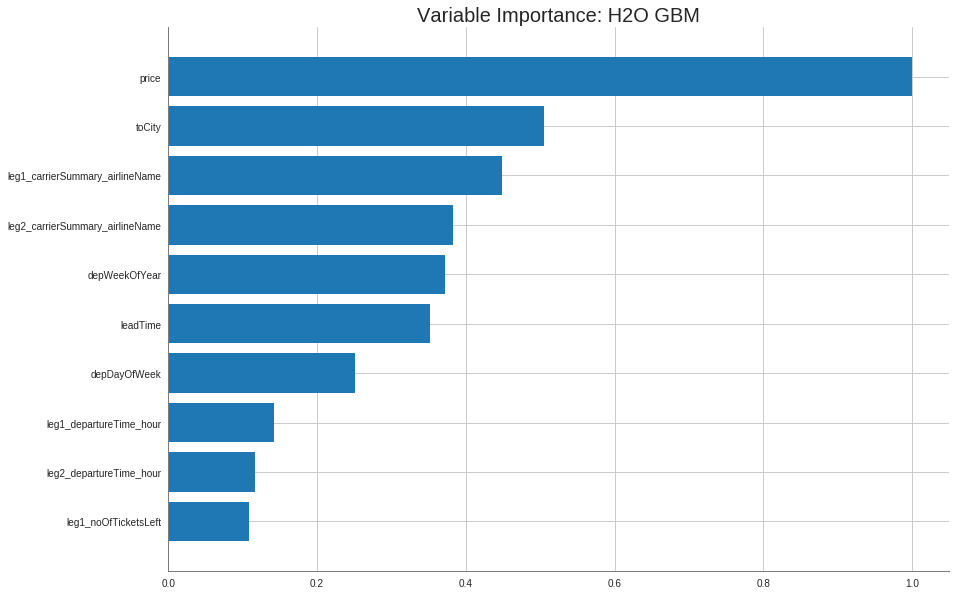

In [65]:
gbm.varimp_plot()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs
############### Modelling: priceWillDrop ################
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24055691550014963: 


,0,1,Error,Rate
0,2931981.0,734972.0,0.2004,(734972.0/3666953.0)
1,265117.0,337896.0,0.4397,(265117.0/603013.0)
Total,3197098.0,1072868.0,0.2342,(1000089.0/4269966.0)


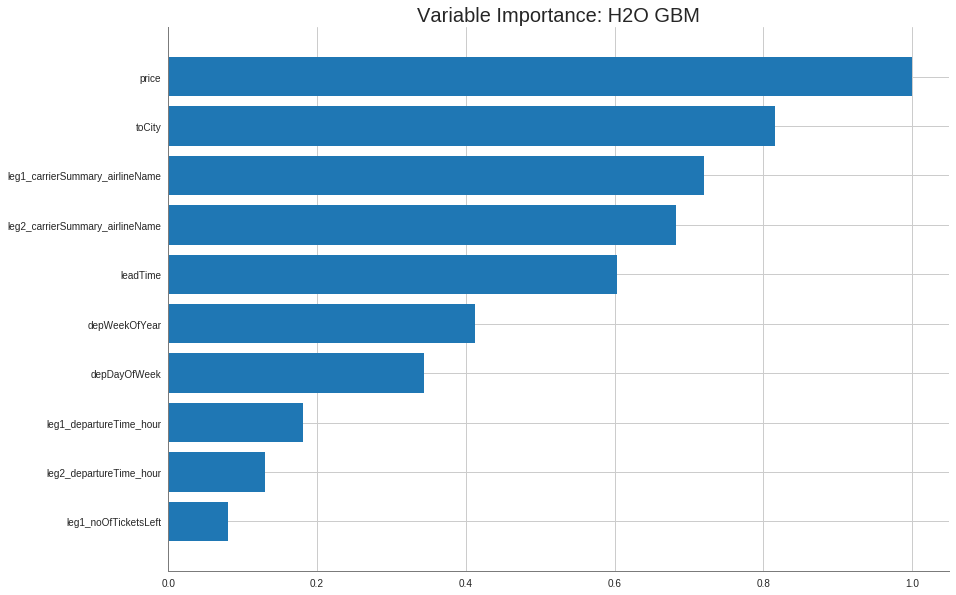

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Column toCity's cardinality of 30 > nbins of 21
  Request: POST /3/PartialDependence/
    data: {'cols': '[toCity]', 'model_id': 'GBM_model_python_1512385491799_44', 'frame_id': 'py_100_sid_aebd', 'nbins': '21'}


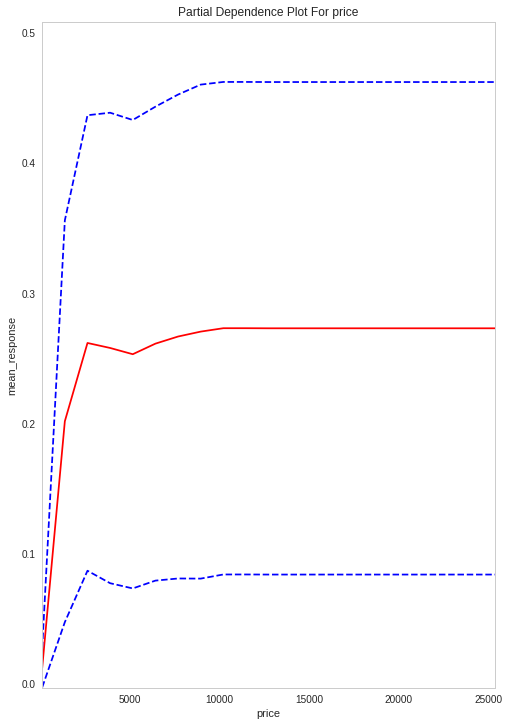

In [110]:
# Run AutoML for 30 seconds
# aml = H2OAutoML(max_runtime_secs = 3600)
# aml.train(x=features, y=target,
#           training_frame = train,
#           validation_frame = valid,
#           leaderboard_frame = test)

# # View the AutoML Leaderboard
# lb = aml.leaderboard
# lb
# # # aml.leader    

# aml.leader

# important_features

# hf[important_features]

%time

imp_threshold = 0.01

print("############### Modelling: " + target + " ################")
# model = aml.leader
model = gbm
print(model.confusion_matrix(valid=True))    
model.varimp_plot()   
important_features = [i[0] for i in model.varimp() if i[3]  > imp_threshold]
for f in important_features:        
    if f in ['price',
             'leg1_carrierSummary_airlineName',
             'depWeekOfYear',
             'leadTime',
#              'leg2_carrierSummary_airlineName',
             'depDayOfWeek',
             'leg1_departureTime_hour',
             'toCity',
             'leg2_departureTime_hour',
             'searchDayOfWeek',
             'leg1_noOfTicketsLeft',
             'leg2_noOfTicketsLeft',
             'fromCity',
             'leg1_stops',
             'trip']:
#             model.partial_plot(data=valid,cols=[f],server=True, plot=True, nbins=272) 
#         else:
        #model.partial_plot(data=test,cols=[f],server=True, plot=True, nbins=21)     #21    
        model.partial_plot(data=hf_valid,cols=[f],server=True, plot=True, nbins=21)     #21    

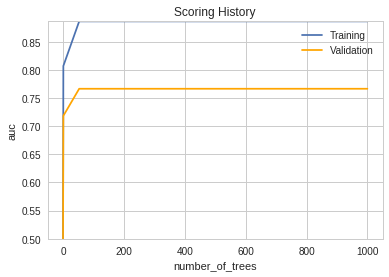

In [111]:
gbm.plot(metric='auc')

# model.download_mojo(path='D:\\flight.pq.11\\', get_genmodel_jar=True)